In [14]:
import pandas as pd
import os
import xml.etree.ElementTree as ET, urllib.request, gzip, io


# Graphs we did quickly

In [15]:
path = r'NASA_cumulative_2023.03.12_03.51.03.csv'

df = pd.read_csv(path, skiprows=144)
df

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,...,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
2,3,10811496,K00753.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,...,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,...,0.147,0.078,0.289,0.079,-0.257,0.072,0.099,0.077,0.276,0.076
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,-0.090,0.180,0.100,0.140,0.070,0.180,0.020,0.160,0.070,0.200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,9560,10090151,K07985.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,...,-1.757,0.068,2.763,0.074,2.344,0.072,-1.756,0.068,2.929,0.072
9560,9561,10128825,K07986.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.497,0,...,-0.250,0.490,0.780,0.460,0.500,0.400,-0.180,0.470,0.530,0.470
9561,9562,10147276,K07987.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.021,0,...,-3.650,0.260,5.000,0.220,3.380,0.160,-3.890,0.260,5.160,0.220
9562,9563,10155286,K07988.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.092,0,...,1.320,0.670,1.690,0.530,1.450,0.110,1.370,0.660,2.000,0.460


<AxesSubplot:>

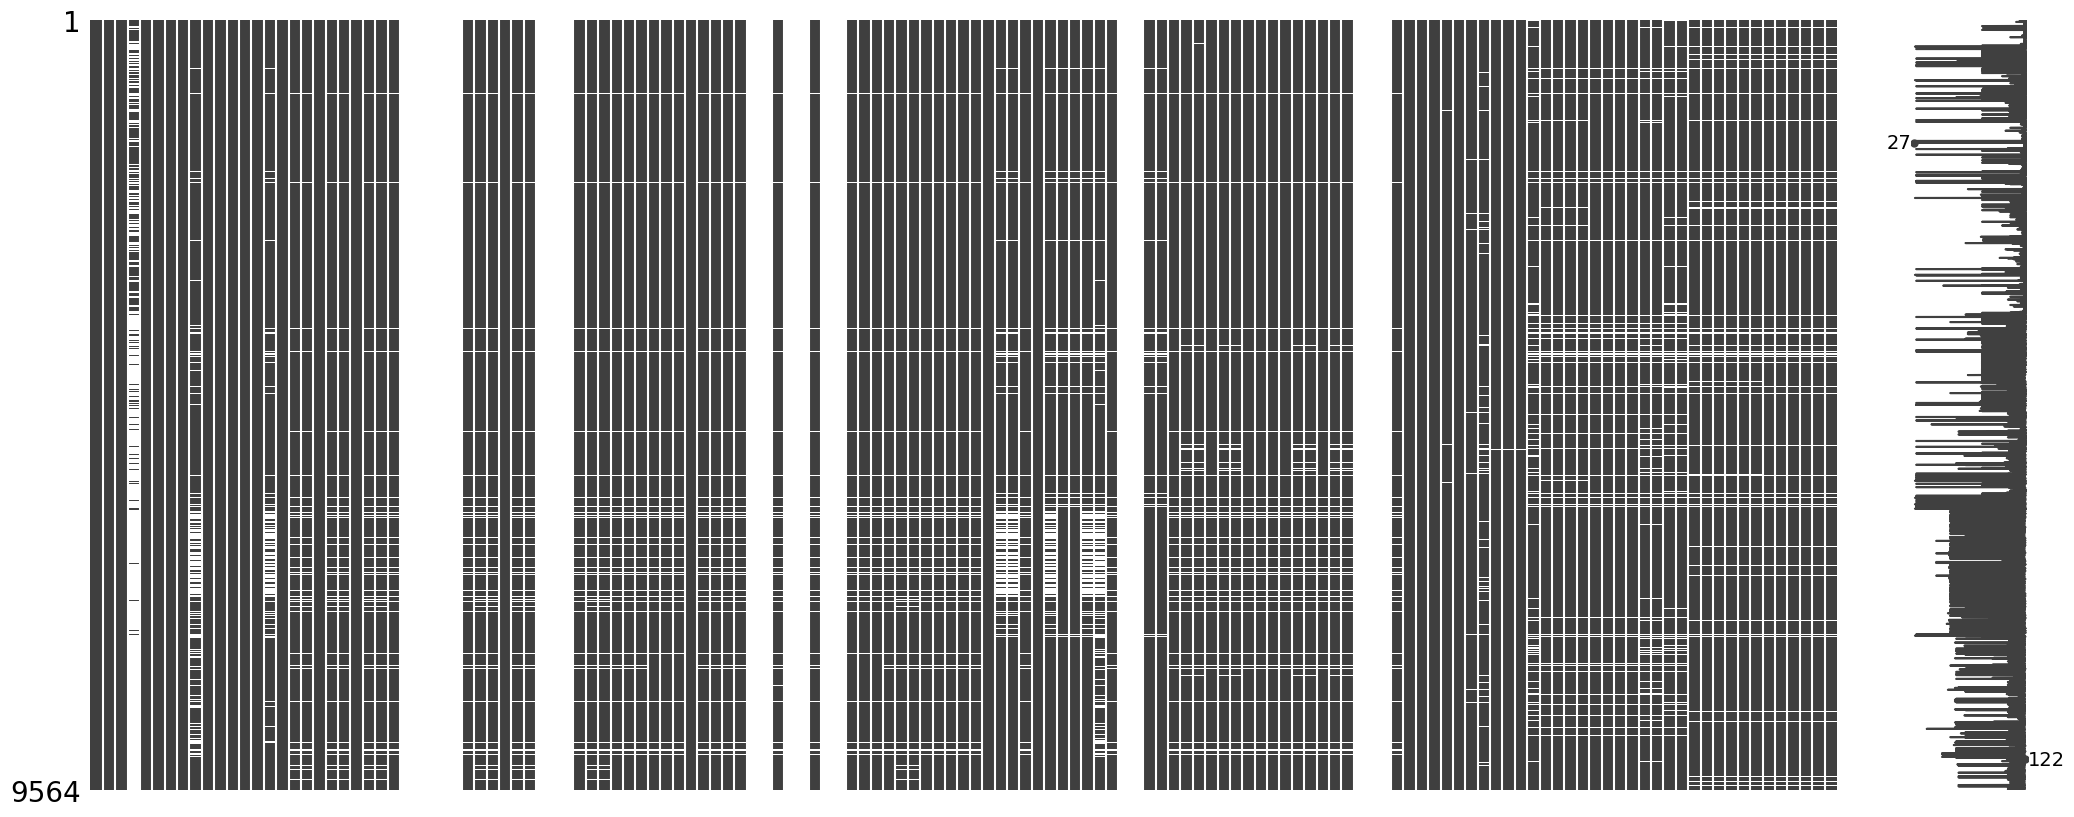

In [16]:
import missingno as msno
msno.matrix(pd.concat([df]))

<AxesSubplot:title={'center':'Pearson Correlation of Features on a heatmap'}>

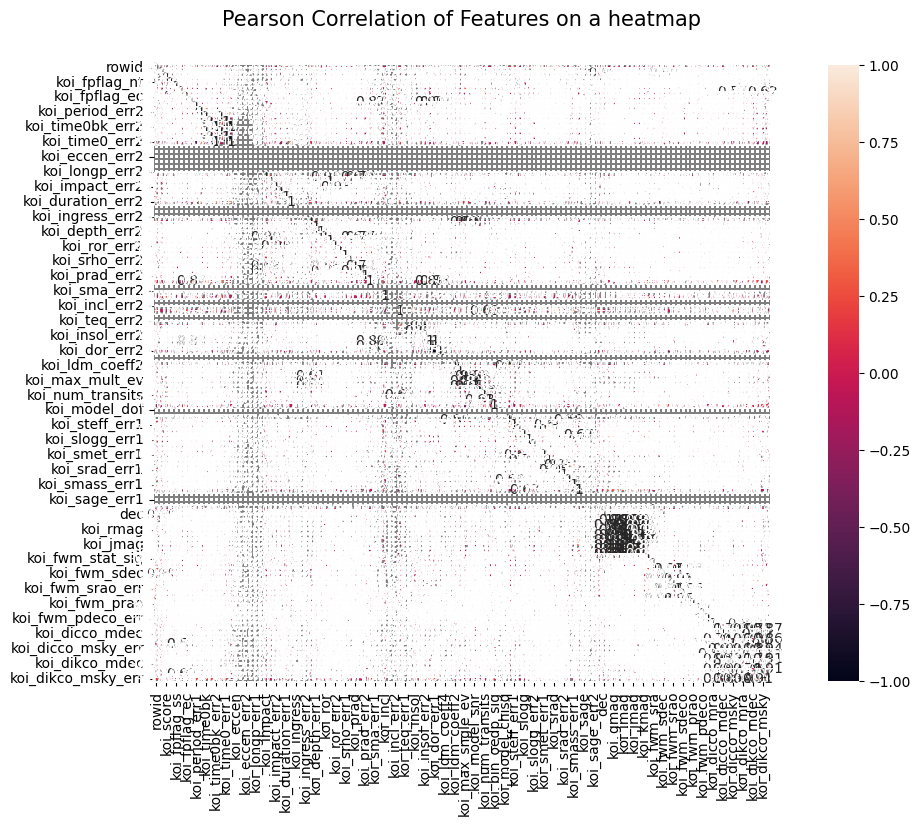

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
# Look at the correlation between the data
plt.figure(figsize=(15,8))
plt.title('Pearson Correlation of Features on a heatmap', y=1.05, size=15)
sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, square=True, linecolor='grey', annot=True)

In [18]:
df.head()

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,...,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
2,3,10811496,K00753.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,...,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,...,0.147,0.078,0.289,0.079,-0.257,0.072,0.099,0.077,0.276,0.076
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,-0.090,0.180,0.100,0.140,0.070,0.180,0.020,0.160,0.070,0.200


In [19]:
import plotly.express as px


fig = px.bar(df, x="koi_disposition", y="rowid", title="Long-Form Input")
fig.show()

In [20]:
import plotly.express as px

fig = px.histogram(df, x="koi_disposition", text_auto=True)
fig.show()

In [21]:
df['sum-group'] = 1
df

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,...,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err,sum-group
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160,1
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,...,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450,1
2,3,10811496,K00753.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,...,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074,1
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,...,0.078,0.289,0.079,-0.257,0.072,0.099,0.077,0.276,0.076,1
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,0.180,0.100,0.140,0.070,0.180,0.020,0.160,0.070,0.200,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,9560,10090151,K07985.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,...,0.068,2.763,0.074,2.344,0.072,-1.756,0.068,2.929,0.072,1
9560,9561,10128825,K07986.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.497,0,...,0.490,0.780,0.460,0.500,0.400,-0.180,0.470,0.530,0.470,1
9561,9562,10147276,K07987.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.021,0,...,0.260,5.000,0.220,3.380,0.160,-3.890,0.260,5.160,0.220,1
9562,9563,10155286,K07988.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.092,0,...,0.670,1.690,0.530,1.450,0.110,1.370,0.660,2.000,0.460,1


In [22]:
# Plotting the pie chart for above dataframe
gro = df.groupby(['koi_disposition']).sum().reset_index()

fig = px.pie(gro, values='sum-group', names='koi_disposition', title='Population of European continent')
fig.show()

In [23]:
for col in df.columns:
  print(col)

rowid
kepid
kepoi_name
kepler_name
koi_disposition
koi_vet_stat
koi_vet_date
koi_pdisposition
koi_score
koi_fpflag_nt
koi_fpflag_ss
koi_fpflag_co
koi_fpflag_ec
koi_disp_prov
koi_comment
koi_period
koi_period_err1
koi_period_err2
koi_time0bk
koi_time0bk_err1
koi_time0bk_err2
koi_time0
koi_time0_err1
koi_time0_err2
koi_eccen
koi_eccen_err1
koi_eccen_err2
koi_longp
koi_longp_err1
koi_longp_err2
koi_impact
koi_impact_err1
koi_impact_err2
koi_duration
koi_duration_err1
koi_duration_err2
koi_ingress
koi_ingress_err1
koi_ingress_err2
koi_depth
koi_depth_err1
koi_depth_err2
koi_ror
koi_ror_err1
koi_ror_err2
koi_srho
koi_srho_err1
koi_srho_err2
koi_fittype
koi_prad
koi_prad_err1
koi_prad_err2
koi_sma
koi_sma_err1
koi_sma_err2
koi_incl
koi_incl_err1
koi_incl_err2
koi_teq
koi_teq_err1
koi_teq_err2
koi_insol
koi_insol_err1
koi_insol_err2
koi_dor
koi_dor_err1
koi_dor_err2
koi_limbdark_mod
koi_ldm_coeff4
koi_ldm_coeff3
koi_ldm_coeff2
koi_ldm_coeff1
koi_parm_prov
koi_max_sngle_ev
koi_max_mult_ev
koi_

In [24]:
columns = ['koi_disposition', 'koi_time0bk', 'koi_impact', 'koi_duration', 
'koi_ror','koi_prad',]
df1 = pd.DataFrame(df, columns=columns)

In [25]:
sns.set_palette("Paired")
# sns.color_palette("")
sns.color_palette()

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

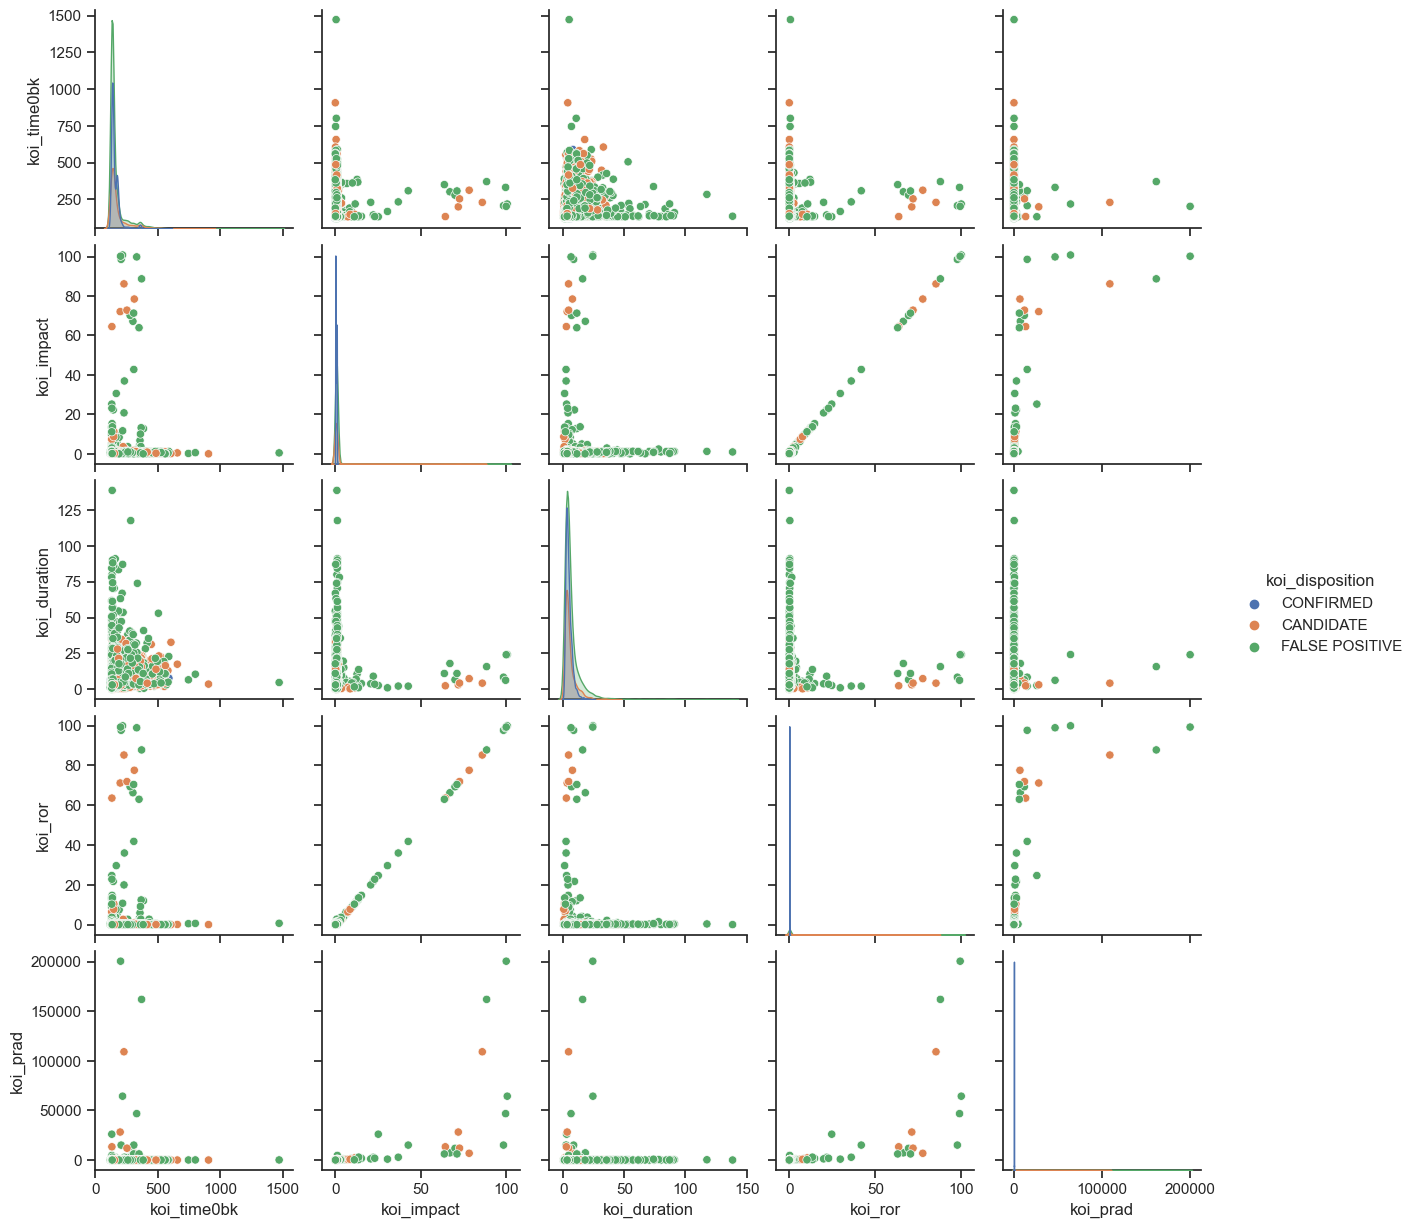

In [26]:
sns.set(style="ticks")
sns.pairplot(df1, hue="koi_disposition")

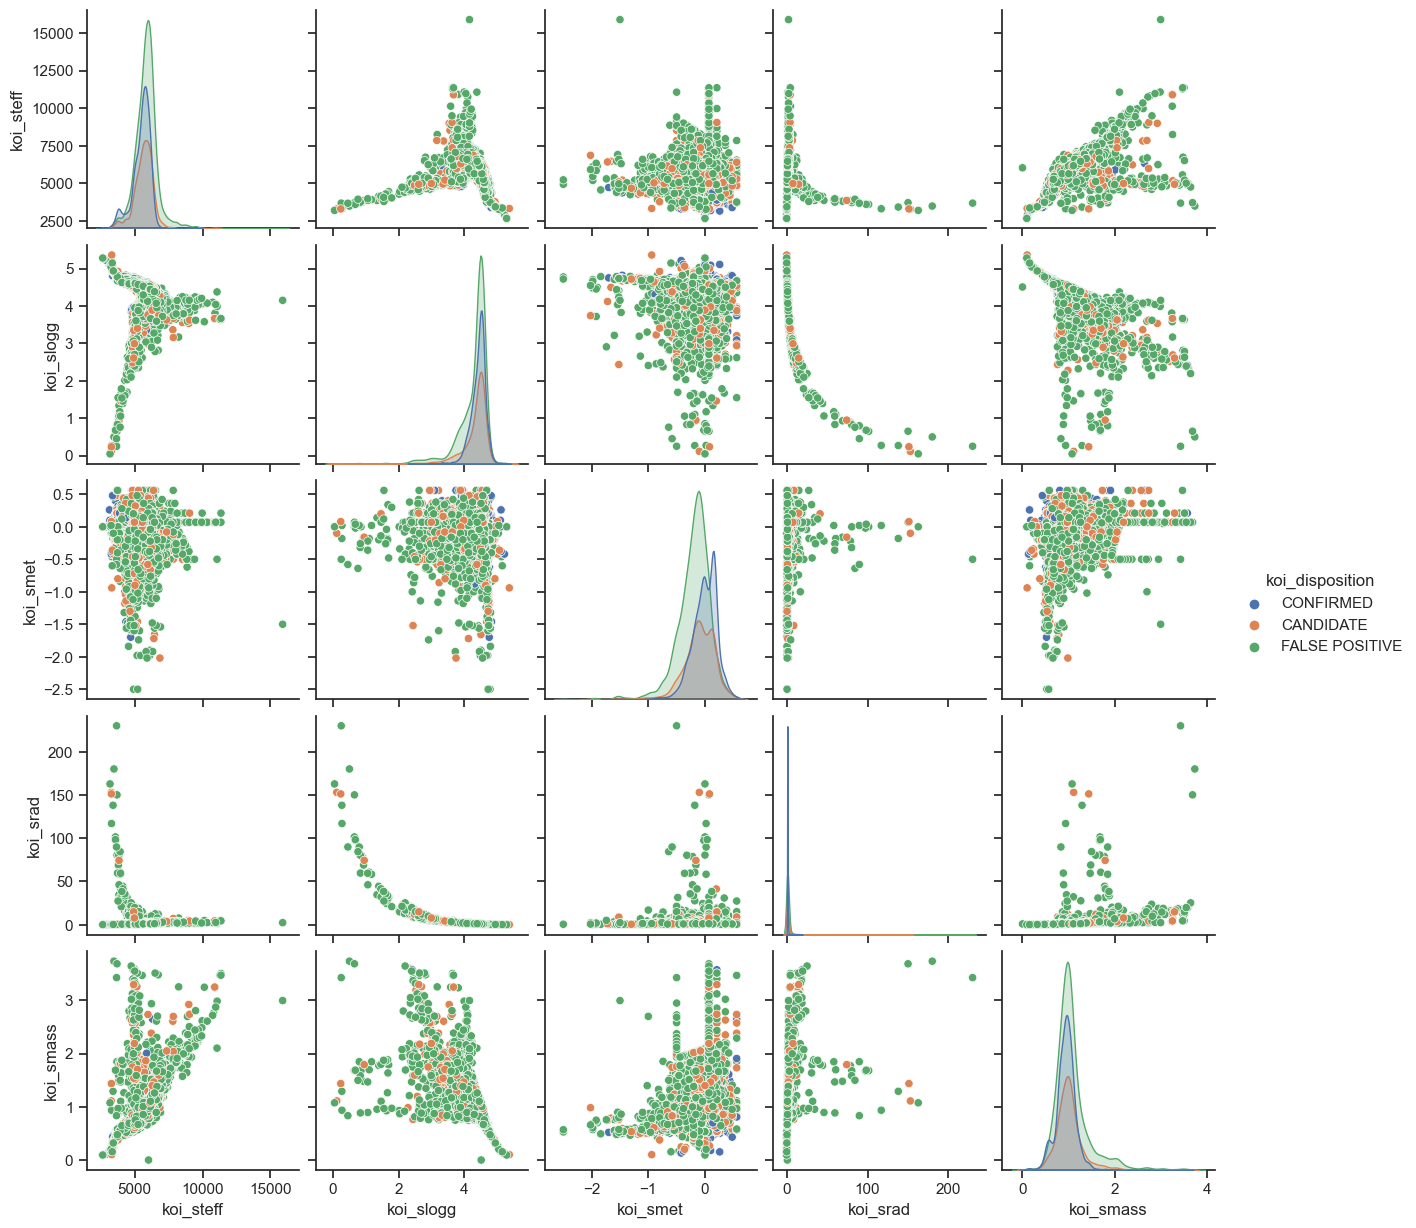

In [27]:
# Stellar Parameters
columns = ['koi_disposition', 'koi_steff', 'koi_slogg', 'koi_smet',
           'koi_srad', 'koi_smass', 'koi_sparprov' ]
df2 = pd.DataFrame(df, columns=columns)

sns.set(style="ticks")
# sns.set_palette("husl")
sns.pairplot(df2, hue="koi_disposition")

# Read the Datasets

## 1. NASA

- Updated regularly.
- Documentation of the column meaning can be found here: https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html



In [28]:
#https://drive.google.com/file/d/1WfxroJ_5XD5NE14ZAM4GvsUWoLgI0k1v/view?usp=share_link
!gdown "1WfxroJ_5XD5NE14ZAM4GvsUWoLgI0k1v&confirm=t" 

'gdown' is not recognized as an internal or external command,
operable program or batch file.


In [29]:
nasa_df = pd.read_csv('NASA_cumulative_2023.03.12_03.51.03.csv', skiprows=144)
nasa_df.set_index('rowid', inplace=True)
nasa_df

,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
rowid,,,,,,,,,,,,,,,,,,,,,
1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,0,...,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
3,10811496,K00753.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,0,...,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
4,10848459,K00754.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,1,...,0.147,0.078,0.289,0.079,-0.257,0.072,0.099,0.077,0.276,0.076
5,10854555,K00755.01,Kepler-664 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,-0.090,0.180,0.100,0.140,0.070,0.180,0.020,0.160,0.070,0.200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9560,10090151,K07985.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,1,...,-1.757,0.068,2.763,0.074,2.344,0.072,-1.756,0.068,2.929,0.072
9561,10128825,K07986.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.497,0,0,...,-0.250,0.490,0.780,0.460,0.500,0.400,-0.180,0.470,0.530,0.470
9562,10147276,K07987.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.021,0,0,...,-3.650,0.260,5.000,0.220,3.380,0.160,-3.890,0.260,5.160,0.220


## 2. Open Exoplanet Catalogue

- This dataset is updated regularly.
- The data is stored in human readable XML files.
- There is one separate file for each planetary system.
- Link to the dataset: https://openexoplanetcatalogue.com/

Read about the different features here: https://github.com/OpenExoplanetCatalogue/open_exoplanet_catalogue/


In [30]:
url = "https://github.com/OpenExoplanetCatalogue/oec_gzip/raw/master/systems.xml.gz"
oec = ET.parse(gzip.GzipFile(fileobj=io.BytesIO(urllib.request.urlopen(url).read())))
 


## 3. The Exoplanet Orbit Database

- Only updated until June 2018.
- Link to the dataset http://exoplanets.org/table
- Documentation of the columns http://exoplanets.org/help/common/data


In [33]:
orbit_df = pd.read_csv('the_exoplanet_orbit_database.csv')
orbit_df

,NAME,MSINI-mjupiter,A-au,PER-day,ECC,OM-deg,T0-jd,K-m/s,ORBREF,ORBURL,...,RHK,JSNAME,EPEURL,KP,SIMBADNAME,SIMBADURL,ETDNAME,ETDURL,EANAME,EAURL
0,Kepler-107 d,NaN,0.078010,7.958203,NaN,90.0,2454970.800,NaN,Rowe 2014,http://adsabs.harvard.edu/abs/2014arXiv1402.6534R,...,NaN,Kepler-107,http://exoplanet.eu/star.php?st=Kepler-107,NaN,Kepler-107,http://simbad.harvard.edu/simbad/sim-id?Ident=...,NaN,NaN,Kepler-107 d,http://exoplanetarchive.ipac.caltech.edu/cgi-b...
1,Kepler-1049 b,NaN,0.034472,3.273461,0.0,90.0,NaN,NaN,Morton 2016,http://adsabs.harvard.edu/abs/2016ApJ...822...86M,...,NaN,NaN,NaN,14.220,NaN,NaN,NaN,NaN,Kepler-1049 b,http://exoplanetarchive.ipac.caltech.edu/cgi-b...
2,Kepler-813 b,NaN,0.137610,19.129473,0.0,90.0,NaN,NaN,Morton 2016,http://adsabs.harvard.edu/abs/2016ApJ...822...86M,...,NaN,NaN,NaN,14.569,NaN,NaN,NaN,NaN,Kepler-813 b,http://exoplanetarchive.ipac.caltech.edu/cgi-b...
3,Kepler-427 b,0.310432,0.091351,10.290994,0.0,90.0,2454970.022,29.8,Hebrard 2014,http://adsabs.harvard.edu/abs/2014A%26A...572A...,...,NaN,KOI-192 b,http://exoplanet.eu/star.php?st=KOI-192+b,14.220,2MASS J19130109+4342175,http://simbad.harvard.edu/simbad/sim-id?Ident=...,NaN,NaN,NaN,NaN
4,Kepler-1056 b,NaN,0.185149,27.495606,0.0,90.0,NaN,NaN,Morton 2016,http://adsabs.harvard.edu/abs/2016ApJ...822...86M,...,NaN,NaN,NaN,14.550,NaN,NaN,NaN,NaN,Kepler-1056 b,http://exoplanetarchive.ipac.caltech.edu/cgi-b...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5742,KOI 7978.01,NaN,0.082100,7.268182,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,13.729,NaN,NaN,NaN,NaN,K07978.01,http://exoplanetarchive.ipac.caltech.edu/cgi-b...
5743,KOI 7982.01,NaN,1.028700,376.379890,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,15.632,NaN,NaN,NaN,NaN,K07982.01,http://exoplanetarchive.ipac.caltech.edu/cgi-b...
5744,KOI 8193.01,NaN,0.995500,367.947848,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,15.719,NaN,NaN,NaN,NaN,K08193.01,http://exoplanetarchive.ipac.caltech.edu/cgi-b...
5745,KOI 7986.01,NaN,0.029000,1.739849,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14.757,NaN,NaN,NaN,NaN,K07986.01,http://exoplanetarchive.ipac.caltech.edu/cgi-b...


## 4. The Extrasolar Planets Encyclopaedia

- Developed and maintained by the exoplanet TEAM 
- Updated regularly.
- Link: http://exoplanet.eu/catalog/
- Documentation of columns http://exoplanet.eu/readme/

In [34]:
encyclo_df = pd.read_csv('the_extrasolar_planets_encyclopaedia.csv')
encyclo_df.head(5)

,# name,planet_status,mass,mass_error_min,mass_error_max,mass_sini,mass_sini_error_min,mass_sini_error_max,radius,radius_error_min,...,star_sp_type,star_age,star_age_error_min,star_age_error_max,star_teff,star_teff_error_min,star_teff_error_max,star_detected_disc,star_magnetic_field,star_alternate_names
0,11 Com b,Confirmed,NaN,NaN,NaN,16.1284,1.53491,1.53491,NaN,NaN,...,G8 III,NaN,NaN,NaN,4742.0,100.0,100.0,NaN,NaN,NaN
1,11 Oph b,Confirmed,21.000,3.00,3.000,NaN,NaN,NaN,NaN,NaN,...,M9,0.011,0.002,0.002,2375.0,175.0,175.0,NaN,NaN,"Oph 1622-2405, Oph 11A"
2,11 UMi b,Confirmed,NaN,NaN,NaN,11.0873,1.10000,1.10000,NaN,NaN,...,K4III,1.560,0.540,0.540,4340.0,70.0,70.0,NaN,NaN,NaN
3,14 And b,Confirmed,NaN,NaN,NaN,4.6840,0.23000,0.23000,NaN,NaN,...,K0III,NaN,NaN,NaN,4813.0,20.0,20.0,NaN,NaN,NaN
4,14 Her b,Confirmed,9.653,1.67,2.331,5.2150,0.30000,0.30000,NaN,NaN,...,K0 V,5.100,NaN,NaN,5311.0,87.0,87.0,NaN,NaN,NaN


# Data Examination

In [35]:
print("There are " + str(nasa_df.shape[0]) + " rows in the NASA data")
print("There are " + str(nasa_df.shape[1]) + " columns in the NASA data")

There are 9564 rows in the NASA data
There are 140 columns in the NASA data


As we can see in the raw data there are 9,564 rows and 140 columns.

We'll print a few rows, and information about the columns in order to see which are numeric or categorical.

In [36]:
# Print the shape of the dataset
print(nasa_df.shape)

#print first 5 rows of the dataset
nasa_df.head()

(9564, 140)


,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
rowid,,,,,,,,,,,,,,,,,,,,,
1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,0,...,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
3,10811496,K00753.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,0,...,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
4,10848459,K00754.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,1,...,0.147,0.078,0.289,0.079,-0.257,0.072,0.099,0.077,0.276,0.076
5,10854555,K00755.01,Kepler-664 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,-0.090,0.180,0.100,0.140,0.070,0.180,0.020,0.160,0.070,0.200


In [37]:
# Analysing type of data
nasa_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9564 entries, 1 to 9564
Data columns (total 140 columns):
 #    Column              Dtype  
---   ------              -----  
 0    kepid               int64  
 1    kepoi_name          object 
 2    kepler_name         object 
 3    koi_disposition     object 
 4    koi_vet_stat        object 
 5    koi_vet_date        object 
 6    koi_pdisposition    object 
 7    koi_score           float64
 8    koi_fpflag_nt       int64  
 9    koi_fpflag_ss       int64  
 10   koi_fpflag_co       int64  
 11   koi_fpflag_ec       int64  
 12   koi_disp_prov       object 
 13   koi_comment         object 
 14   koi_period          float64
 15   koi_period_err1     float64
 16   koi_period_err2     float64
 17   koi_time0bk         float64
 18   koi_time0bk_err1    float64
 19   koi_time0bk_err2    float64
 20   koi_time0           float64
 21   koi_time0_err1      float64
 22   koi_time0_err2      float64
 23   koi_eccen           float64
 24   ko

The column names in the loaded csv is an abbreviation of the full name, here we will load these names and rename the columns with the full feature name.

In [38]:
names = pd.read_csv('NASA_cumulative_2023.03.12_03.51.03.csv',skiprows=3, nrows=140, names=['full'])

names[['A', 'B']] = names['full'].str.split(':', 1, expand=True)
names[['AA', 'AAA']] = names['A'].str.split('COLUMN', 1, expand=True)

names.drop(columns=['full', 'A', 'AA'], inplace=True)
names.rename(columns={'B':'fullname',
                      'AAA':'currentname'}, inplace=True)
names = names.replace(' ', '', regex=True)

names.head()

,fullname,currentname
0,KepID,kepid
1,KOIName,kepoi_name
2,KeplerName,kepler_name
3,ExoplanetArchiveDisposition,koi_disposition
4,VettingStatus,koi_vet_stat


In [39]:
renaming = {}
for i, r in names.iterrows():
  renaming[r.currentname] = r.fullname

#rename columns with their full name
nasa_df = nasa_df.rename(columns=renaming)
nasa_df.head()

,KepID,KOIName,KeplerName,ExoplanetArchiveDisposition,VettingStatus,DateofLastParameterUpdate,DispositionUsingKeplerData,DispositionScore,NotTransit-LikeFalsePositiveFlag,StellarEclipseFalsePositiveFlag,...,PRF&Delta;&delta;<sub>SQ</sub>(OOT)[arcsec],PRF&Delta;&delta;<sub>SQ</sub>(OOT)Unc.[arcsec],PRF&Delta;&theta;<sub>SQ</sub>(OOT)[]arcsec,PRF&Delta;&theta;<sub>SQ</sub>(OOT)Unc.[arcsec],PRF&Delta;&alpha;<sub>SQ</sub>(KIC)[arcsec],PRF&Delta;&alpha;<sub>SQ</sub>(KIC)Unc.[arcsec],PRF&Delta;&delta;<sub>SQ</sub>(KIC)[arcsec],PRF&Delta;&delta;<sub>SQ</sub>(KIC)Unc.[arcsec],PRF&Delta;&theta;<sub>SQ</sub>(KIC)[arcsec],PRF&Delta;&theta;<sub>SQ</sub>(KIC)Unc.[arcsec]
rowid,,,,,,,,,,,,,,,,,,,,,
1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,0,...,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
3,10811496,K00753.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,0,...,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
4,10848459,K00754.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,1,...,0.147,0.078,0.289,0.079,-0.257,0.072,0.099,0.077,0.276,0.076
5,10854555,K00755.01,Kepler-664 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,-0.090,0.180,0.100,0.140,0.070,0.180,0.020,0.160,0.070,0.200


In [40]:
nasa_df['ExoplanetArchiveDisposition'].value_counts()

FALSE POSITIVE    4839
CONFIRMED         2671
CANDIDATE         2054
Name: ExoplanetArchiveDisposition, dtype: int64

### **Create the target column**

We have two columns describing the disposition of a KOI:
* **Disposition Using Kepler Data**
  * This column describes whether a KOI [Kepler Object of Interest] is considered a candidate for an exoplanet, or a false positive, or a confirmed exoplanet.
*   **Exoplanet Archive Disposition** 
  * This column is similar to above, but it also incorporates newer peer-reviewed/published information from the Exoplanet Archive.

Since the second column includes a more fine grained disposition we will use it as our target.
We will create our target called '*ExoplanetConfirmed*' in the following manner:
- 0 if disposition is false positive or candidate.*italicized text*
- 1 if disposition is confirmed. 

In [41]:
nasa_df['ExoplanetConfirmed'] = nasa_df['ExoplanetArchiveDisposition'].apply(lambda x: 1 if x == 'CONFIRMED' else 0)

In [42]:
nasa_df.head(2)

,KepID,KOIName,KeplerName,ExoplanetArchiveDisposition,VettingStatus,DateofLastParameterUpdate,DispositionUsingKeplerData,DispositionScore,NotTransit-LikeFalsePositiveFlag,StellarEclipseFalsePositiveFlag,...,PRF&Delta;&delta;<sub>SQ</sub>(OOT)Unc.[arcsec],PRF&Delta;&theta;<sub>SQ</sub>(OOT)[]arcsec,PRF&Delta;&theta;<sub>SQ</sub>(OOT)Unc.[arcsec],PRF&Delta;&alpha;<sub>SQ</sub>(KIC)[arcsec],PRF&Delta;&alpha;<sub>SQ</sub>(KIC)Unc.[arcsec],PRF&Delta;&delta;<sub>SQ</sub>(KIC)[arcsec],PRF&Delta;&delta;<sub>SQ</sub>(KIC)Unc.[arcsec],PRF&Delta;&theta;<sub>SQ</sub>(KIC)[arcsec],PRF&Delta;&theta;<sub>SQ</sub>(KIC)Unc.[arcsec],ExoplanetConfirmed
rowid,,,,,,,,,,,,,,,,,,,,,
1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,0.16,0.20,0.17,0.08,0.13,0.31,0.17,0.32,0.16,1
2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,0,...,0.48,0.39,0.36,0.49,0.34,0.12,0.73,0.50,0.45,1


### Remove unimportant columns

After the creation of the target class we can remove the other information we have about the kepler disposition, which includes the following columns:


*   **KepID** : id number of the kepler.
*   **KOIName** : the KOI name.
*   **KeplerName** : kepler name.
*   **ExoplanetArchiveDisposition** : the disposition described above.
*   **VettingStatus** : "ACTIVE" or "DONE". Active provides the latest information for follow-up observations, and the transition to "DONE" status occurs when all dispositions are finalized and model parameters are updated appropriately.
*   **DateofLastParameterUpdate** : date of when the keplet info was last updated.
*   **DispositionUsingKeplerData** : the disposition described above.
*   **DispositionScore** : A value between 0 and 1 that indicates the confidence in the KOI disposition.
*   **Comment** : A description of the reason why an object's disposition has been given as false positive.
*   **NotTransit-LikeFalsePositiveFlag** : A KOI whose light curve is not consistent with that of a transiting planet.
*   **DispositionProvenance** : Disposition Provenance



In [43]:
todrop = ['KepID', 'KOIName', 'KeplerName', 'ExoplanetArchiveDisposition', 'VettingStatus', 
        'DateofLastParameterUpdate', 'DispositionUsingKeplerData', 'DispositionScore',
        'Comment', 'NotTransit-LikeFalsePositiveFlag', 
        'DispositionProvenance']

nasa_df.drop(columns=todrop, inplace=True)

In [44]:
nasa_df.head(3)

,StellarEclipseFalsePositiveFlag,CentroidOffsetFalsePositiveFlag,EphemerisMatchIndicatesContaminationFalsePositiveFlag,OrbitalPeriod[days],OrbitalPeriodUpperUnc.[days],OrbitalPeriodLowerUnc.[days],TransitEpoch[BKJD],TransitEpochUpperUnc.[BKJD],TransitEpochLowerUnc.[BKJD],TransitEpoch[BJD],...,PRF&Delta;&delta;<sub>SQ</sub>(OOT)Unc.[arcsec],PRF&Delta;&theta;<sub>SQ</sub>(OOT)[]arcsec,PRF&Delta;&theta;<sub>SQ</sub>(OOT)Unc.[arcsec],PRF&Delta;&alpha;<sub>SQ</sub>(KIC)[arcsec],PRF&Delta;&alpha;<sub>SQ</sub>(KIC)Unc.[arcsec],PRF&Delta;&delta;<sub>SQ</sub>(KIC)[arcsec],PRF&Delta;&delta;<sub>SQ</sub>(KIC)Unc.[arcsec],PRF&Delta;&theta;<sub>SQ</sub>(KIC)[arcsec],PRF&Delta;&theta;<sub>SQ</sub>(KIC)Unc.[arcsec],ExoplanetConfirmed
rowid,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,9.488036,0.000028,-0.000028,170.538750,0.002160,-0.002160,2455003.539,...,0.16,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160,1
2,0,0,0,54.418383,0.000248,-0.000248,162.513840,0.003520,-0.003520,2454995.514,...,0.48,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450,1
3,0,0,0,19.899140,0.000015,-0.000015,175.850252,0.000581,-0.000581,2455008.850,...,0.07,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074,0


In [45]:
print("After removing unimportant columns we have:\n")
print("There are " + str(nasa_df.shape[0]) + " rows in the NASA data")
print("There are " + str(nasa_df.shape[1]) + " columns in the NASA data")

After removing unimportant columns we have:

There are 9564 rows in the NASA data
There are 130 columns in the NASA data


### Remove error columns

Some columns are the errors margins of the calculations in other columns. We will remove these error columns

In [46]:
err_colummns = []

# go over cols and get every col with 'Unc.' in it
for c in nasa_df.columns:
  if 'Unc.' in c:
    err_colummns.append(c)


# finalize changes, but hold on to the data with error in case we need it later
data = nasa_df.drop(err_colummns, axis = 1)

print(f"\nDataset had {nasa_df.shape[1]} columns.\nIt now has {data.shape[1]} columns.")


Dataset had 130 columns.
It now has 72 columns.


# Handle Missing Data

<AxesSubplot:>

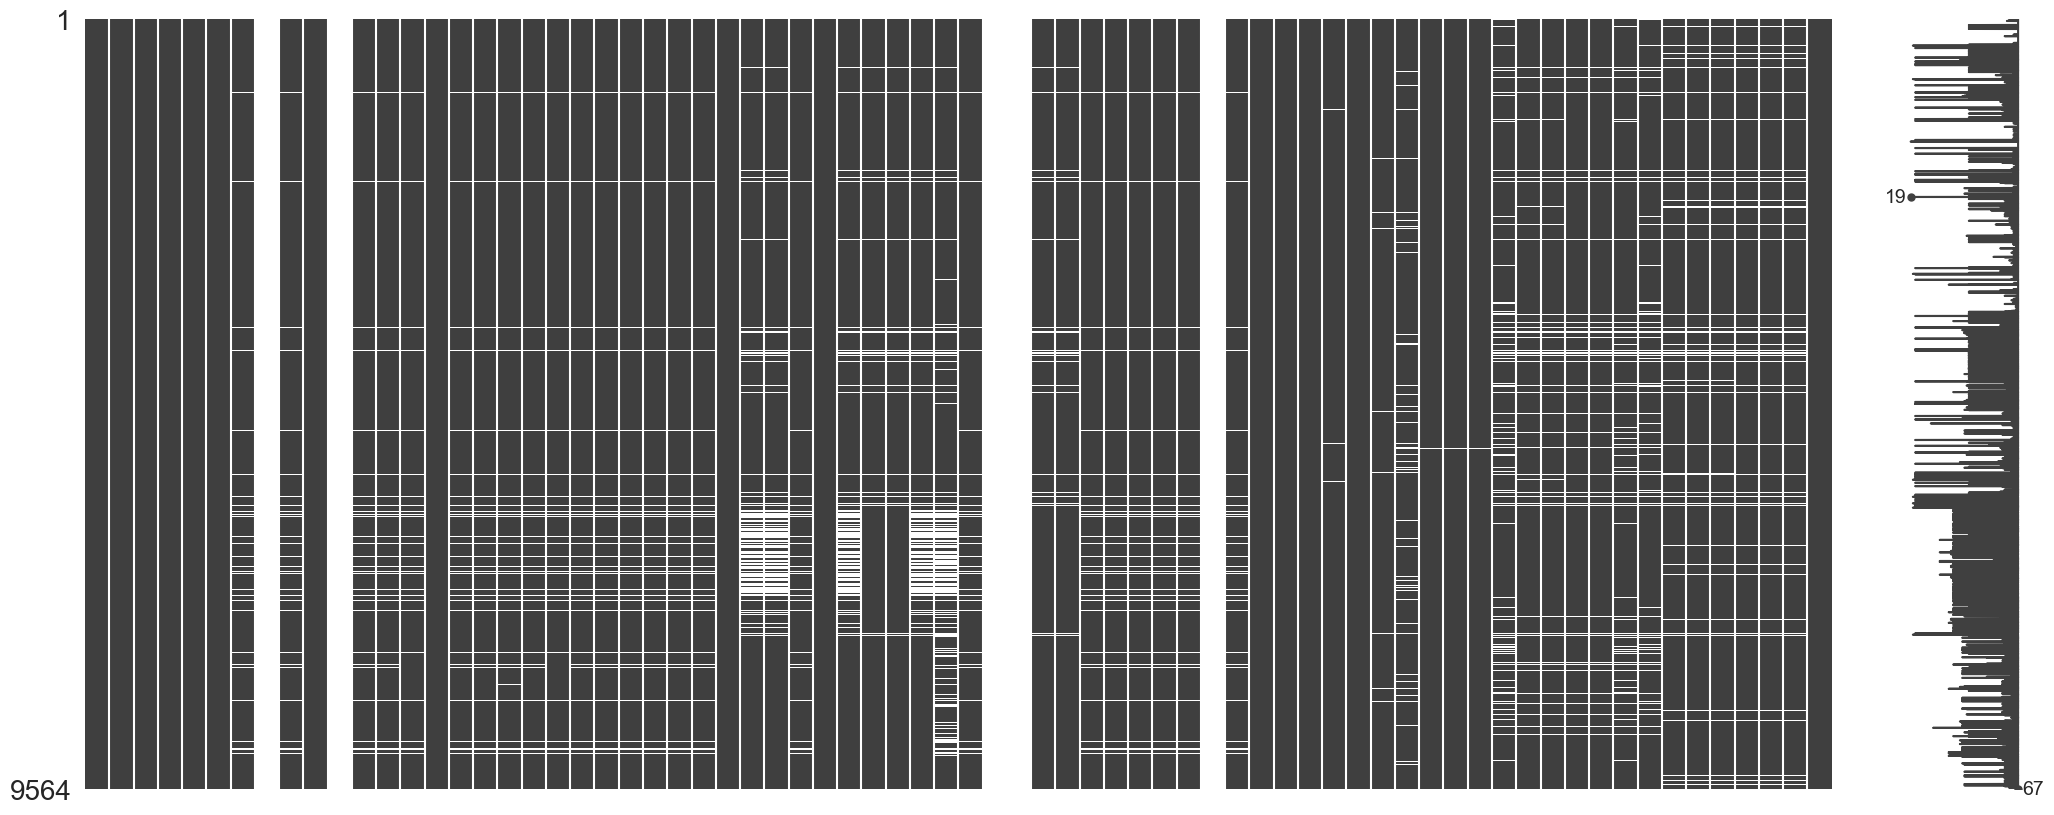

In [47]:
import missingno as msno
msno.matrix(pd.concat([data]))

In [48]:
data.shape

(9564, 72)

### Drop all columns that have more than 50% missing

Here we dropped all columns that have more than 50% of their data missing.

In [49]:
data = data.loc[:, data.isnull().mean() < .5]

In [50]:
data.shape

(9564, 67)

In [51]:
# get columns with missing values, and get unique values in these columns.

temp = []
for col in data.columns:
  m = data[col].isna().sum()
  if m > 0:
    temp.append([col, m, round(m/data.shape[0*100], 2), data[col].unique().tolist()])

missing_df = pd.DataFrame(temp, columns=['column', 'num_missing', 'precentage_missing', 'unique']).sort_values(by=['num_missing'], ascending=False)


In [52]:
missing_df.head(50)

,column,num_missing,precentage_missing,unique
23,Odd-EvenDepthComparisionStatistic,1510,0.16,"[0.6864, 0.0023, 0.6624, 0.0, 0.309, 0.0975, 0..."
22,Quarters,1142,0.12,"[11111111111111111000000000000000, 11111101110..."
19,NumberofTransits,1142,0.12,"[142.0, 25.0, 56.0, 621.0, 515.0, 95.0, 240.0,..."
17,MaximumMultipleEventStatistic,1142,0.12,"[28.47082, 20.109507, 187.4491, 541.8951, 33.1..."
16,MaximumSingleEventStatistic,1142,0.12,"[5.135849, 7.027669, 37.159767, 39.06655, 4.74..."
41,FWOffsetSignificance[percent],1076,0.11,"[0.002, 0.003, 0.278, 0.0, 0.733, nan, 0.063, ..."
46,FW&Delta;&alpha;(OOT)[sec],830,0.09,"[-0.0002, 0.00066, 0.0007, 0.00302, 8e-05, 4e-..."
47,FW&Delta;&delta;(OOT)[arcsec],817,0.09,"[-0.00055, -0.00105, 0.0006, -0.00142, -7e-05,..."
37,z'-band[mag],613,0.06,"[15.006, 15.166, 15.266, 15.241, 15.441, 12.48..."
50,PRF&Delta;&theta;<sub>SQ</sub>(OOT)[]arcsec,599,0.06,"[0.2, 0.39, 0.042, 0.289, 0.1, 0.08, 0.26, 0.4..."


<AxesSubplot:>

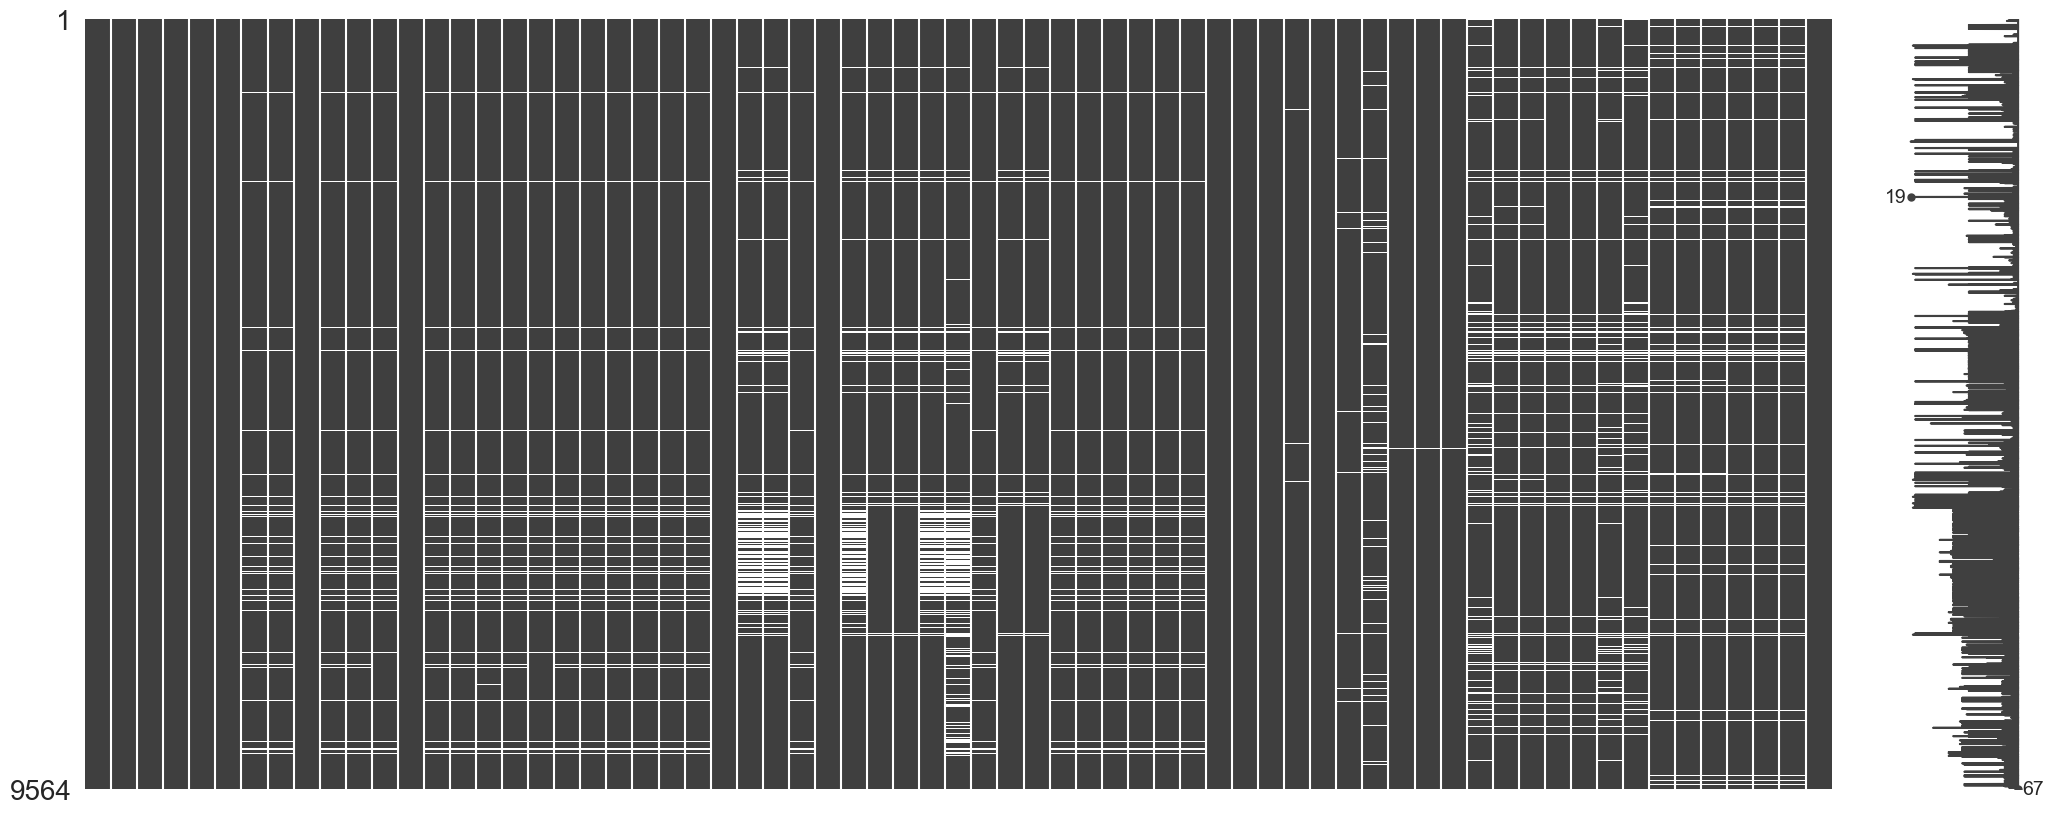

In [53]:
import missingno as msno
msno.matrix(pd.concat([data]))

In [54]:
df_nan = pd.DataFrame(data.isna().mean().reset_index()).rename(columns={"index": "columns", 0: "nan_pourcentage"}).sort_values(by='nan_pourcentage',ascending=False)

### Drop all rows that have more than 50% missing

In [55]:
per_row = []
for index in range(len(data.index)) :
  per_row.append([index, data.iloc[index].isna().mean()])

row_missing = pd.DataFrame(per_row, columns=['index', 'missing']).sort_values(by='missing', ascending=False)

In [56]:
rows_to_delete = list(row_missing.loc[row_missing['missing'] > 0.5].index)
data = data.drop(rows_to_delete,axis='index')

<AxesSubplot:>

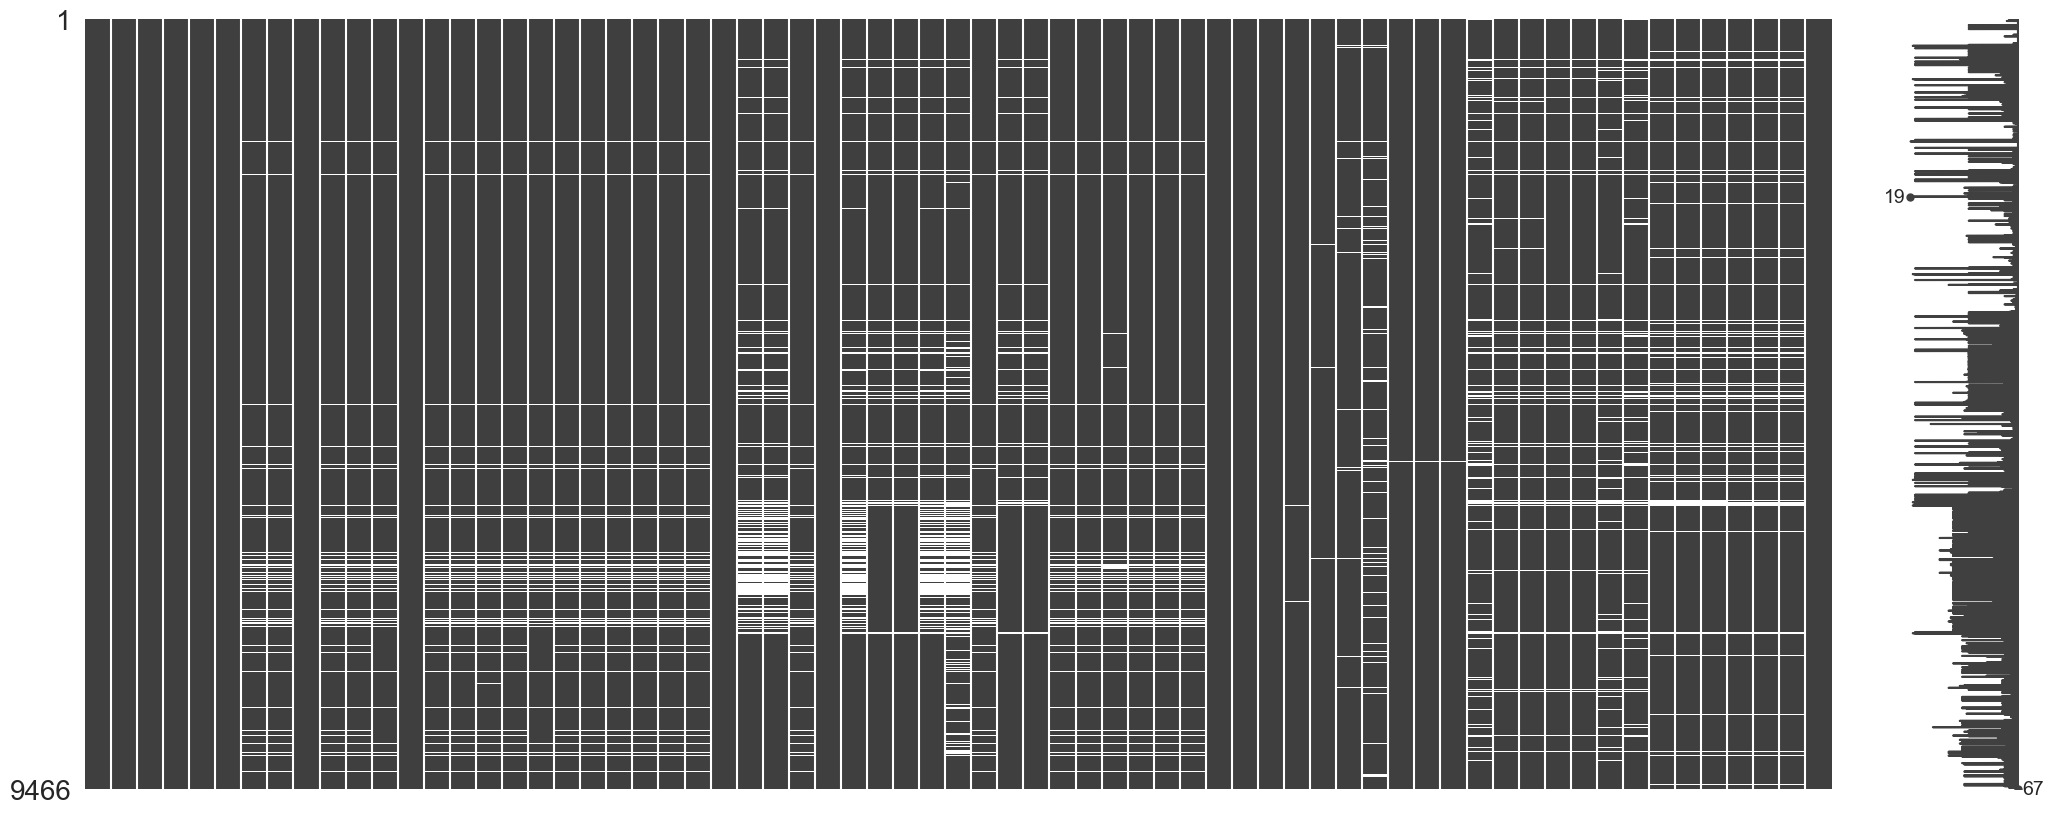

In [57]:
msno.matrix(pd.concat([data]))

<h2><b> Encoding categorical data </b></h2>

In [72]:
df_categorical = data.select_dtypes(object)

<h4><b> Drop all columns that either contain 1 category, or contain too many categories. </b></h4>

In [89]:
df_categorical.drop(['LimbDarkeningModel', 'TransitModel', 'LinktoDVReport', 'LinktoDVSummary', 'Quarters'], axis=1, inplace=True)

In [90]:
df_categorical

,PlanetaryFitType,ParametersProvenance,TCEDelivery,StellarParameterProvenance
rowid,,,,
1,LS+MCMC,q1_q17_dr25_koi,q1_q17_dr25_tce,q1_q17_dr25_stellar
2,LS+MCMC,q1_q17_dr25_koi,q1_q17_dr25_tce,q1_q17_dr25_stellar
3,LS+MCMC,q1_q17_dr25_koi,q1_q17_dr25_tce,q1_q17_dr25_stellar
4,LS+MCMC,q1_q17_dr25_koi,q1_q17_dr25_tce,q1_q17_dr25_stellar
5,LS+MCMC,q1_q17_dr25_koi,q1_q17_dr25_tce,q1_q17_dr25_stellar
...,...,...,...,...
9560,LS+MCMC,q1_q17_dr25_koi,q1_q17_dr25_tce,q1_q17_dr25_stellar
9561,LS+MCMC,q1_q17_dr25_koi,q1_q17_dr25_tce,q1_q17_dr25_stellar
9562,LS+MCMC,q1_q17_dr25_koi,q1_q17_dr25_tce,q1_q17_dr25_stellar


<h4><b> One-hot encode all categories. </b></h4>

In [92]:
#categorical data
categorical_cols = ['PlanetaryFitType', 'ParametersProvenance', 'TCEDelivery', 'StellarParameterProvenance'] 

#import pandas as pd
df_categorical = pd.get_dummies(df_categorical, columns = categorical_cols)

In [93]:
df_categorical # We will merge this with the working DF and delete the categorical columns.

,PlanetaryFitType_LS,PlanetaryFitType_LS+MCMC,PlanetaryFitType_MCMC,PlanetaryFitType_none,ParametersProvenance_q1_q16_koi,ParametersProvenance_q1_q17_dr24_koi,ParametersProvenance_q1_q17_dr25_koi,TCEDelivery_q1_q16_tce,TCEDelivery_q1_q17_dr24_tce,TCEDelivery_q1_q17_dr25_tce,StellarParameterProvenance_Solar,StellarParameterProvenance_q1_q17_dr25_stellar,StellarParameterProvenance_stellar_q1_q16,StellarParameterProvenance_stellar_q1_q17
rowid,,,,,,,,,,,,,,
1,0,1,0,0,0,0,1,0,0,1,0,1,0,0
2,0,1,0,0,0,0,1,0,0,1,0,1,0,0
3,0,1,0,0,0,0,1,0,0,1,0,1,0,0
4,0,1,0,0,0,0,1,0,0,1,0,1,0,0
5,0,1,0,0,0,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9560,0,1,0,0,0,0,1,0,0,1,0,1,0,0
9561,0,1,0,0,0,0,1,0,0,1,0,1,0,0
9562,0,1,0,0,0,0,1,0,0,1,0,1,0,0


<p><b> Drop all categorical data and concat the encoded ones </b></p>

In [104]:
data.drop(categorical_cols + ['LimbDarkeningModel', 'TransitModel', 'LinktoDVReport', 'LinktoDVSummary'], axis=1, inplace=True)

In [106]:
data = pd.concat([data, df_categorical], axis=1)

<h4><b> Handle 0.0/NaN columns </b></h4>

In [120]:
data.drop(['Eccentricity', 'LimbDarkeningCoeff.4', 'LimbDarkeningCoeff.3', 'Quarters'], axis=1, inplace=True)

<h2><b> Imputation </b></h2>

In [126]:
from sklearn.impute import KNNImputer
df_imputer_knn = data.copy(deep=True)

In [127]:
# Impute the feature
knnimputer = KNNImputer(n_neighbors=3)
df_imputer_knn.iloc[:,:] = knnimputer.fit_transform(df_imputer_knn)

<AxesSubplot:>

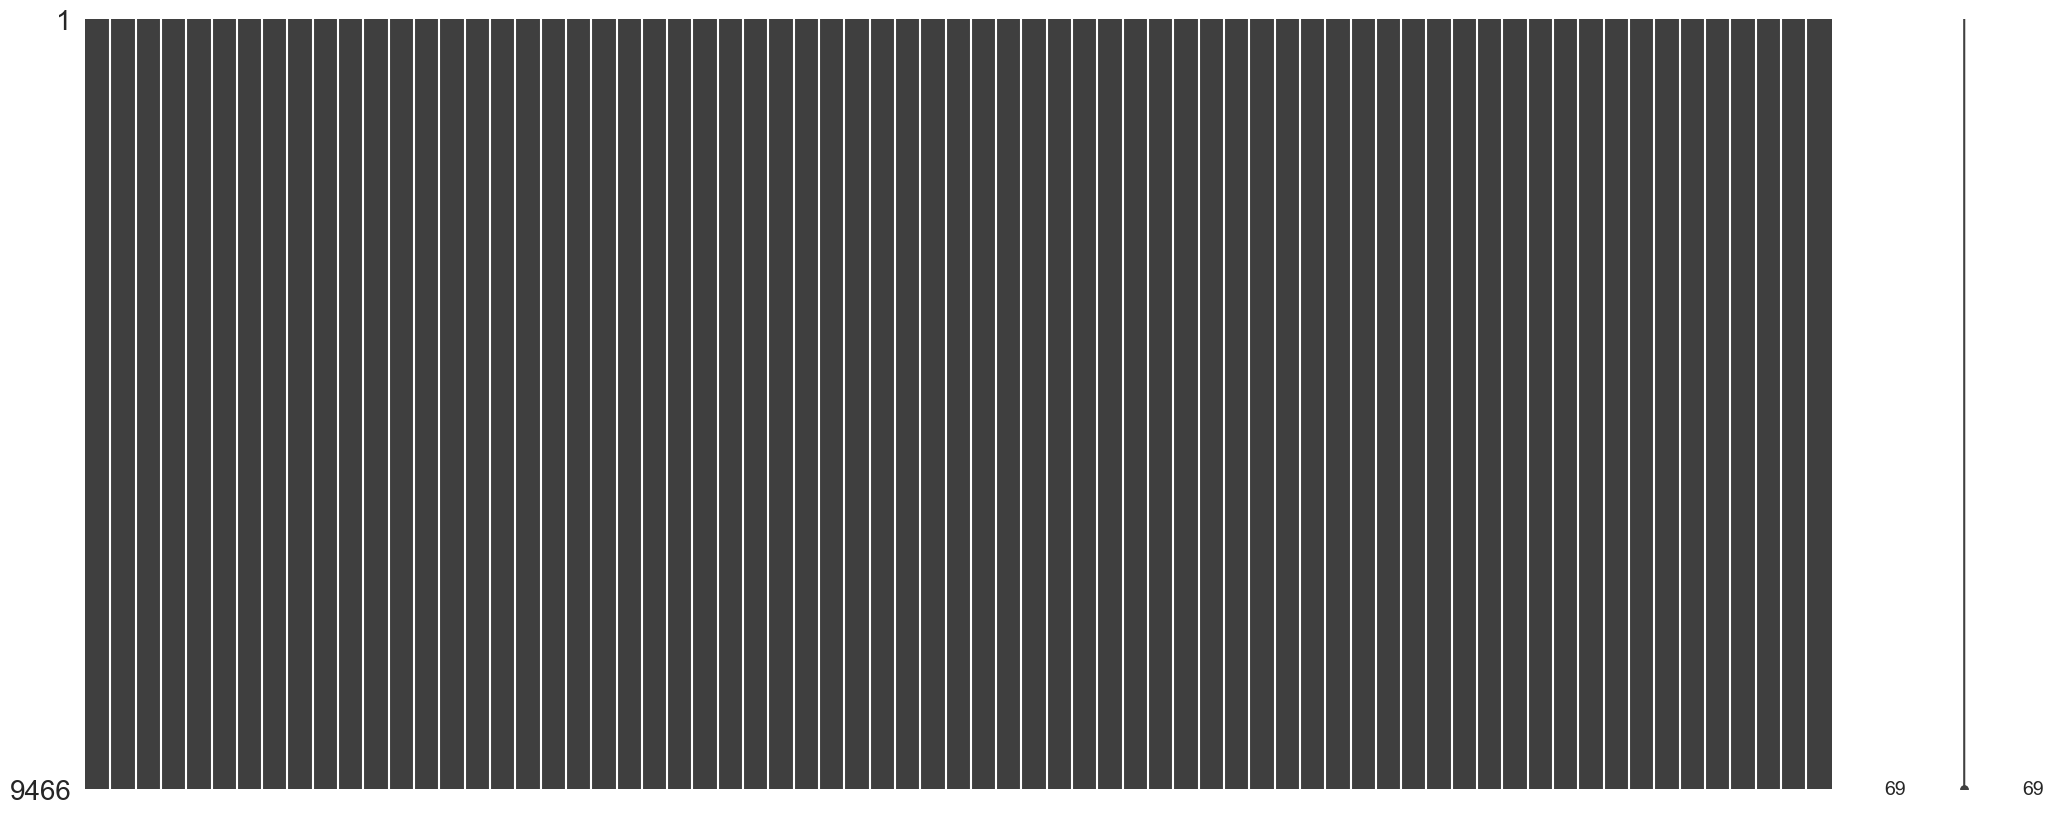

In [129]:
msno.matrix(pd.concat([df_imputer_knn]))

<h2><b> Feature Importance </b></h2>

In [107]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [130]:
X = df_imputer_knn.drop('ExoplanetConfirmed', axis=1)
y = df_imputer_knn['ExoplanetConfirmed']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [131]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [132]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

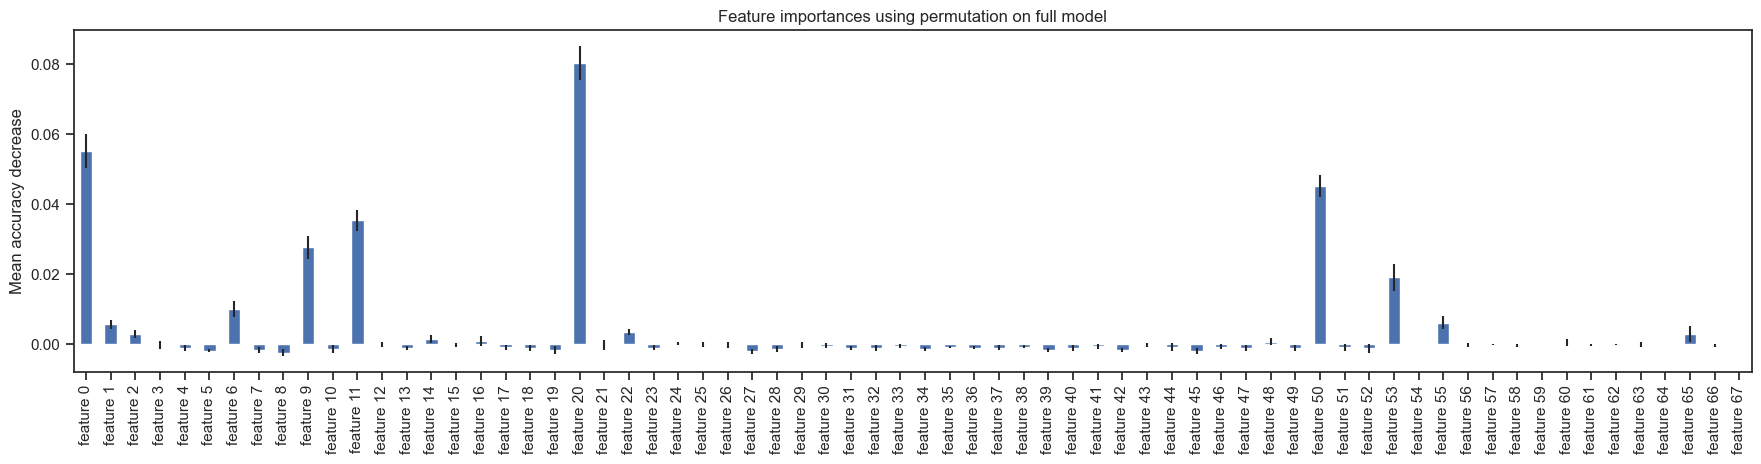

In [137]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
fig.set_figwidth(20)
plt.show()